En esta práctica, aprenderemos a utilizar a hacer aprendizaje transferido (finetuning) con transformadores para realizar el análisis de sentimiento del dataset de Multilingual Amazon Reviews Corpus.

# Análisis, preprocesamiento y preparación de los datos

In [3]:
#Cargamos los datasets

from google.colab import drive

amazon_en_train = 'amazon_dataset_en_train.csv'
amazon_en_dev = 'amazon_dataset_en_dev.csv'
amazon_en_test = 'amazon_dataset_en_test.csv'

Vamos a concatenar todos los splits del dataset en un único dataframe, en el que creamos una columna especificando si el split es el dataset de entrenamiento, de validación o de evaluación.

In [4]:
import pandas as pd

file_names = [(amazon_en_train, "train"), (amazon_en_dev, "dev"), (amazon_en_test, "test")]

df_list = []

for file_name, split_name in file_names:
  df = pd.read_csv(file_name)
  df["split"] = split_name
  df_list.append(df)

df = pd.concat(df_list)
df

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,split
0,en_0964290,product_en_0740675,reviewer_en_0342986,1,Arrived broken. Manufacturer defect. Two of th...,I'll spend twice the amount of time boxing up ...,en,furniture,train
1,en_0690095,product_en_0440378,reviewer_en_0133349,1,the cabinet dot were all detached from backing...,Not use able,en,home_improvement,train
2,en_0311558,product_en_0399702,reviewer_en_0152034,1,I received my first order of this product and ...,The product is junk.,en,home,train
3,en_0044972,product_en_0444063,reviewer_en_0656967,1,This product is a piece of shit. Do not buy. D...,Fucking waste of money,en,wireless,train
4,en_0784379,product_en_0139353,reviewer_en_0757638,1,went through 3 in one day doesn't fit correct ...,bubble,en,pc,train
...,...,...,...,...,...,...,...,...,...
4995,en_0681530,product_en_0198517,reviewer_en_0539725,5,"It's still early, but so far the scales seems ...",Very sleek.,en,drugstore,test
4996,en_0157408,product_en_0206198,reviewer_en_0605408,5,I’ve used this face mask a few times now and i...,... face mask a few times now and it works gre...,en,beauty,test
4997,en_0542558,product_en_0525205,reviewer_en_0727937,5,Great price. Good quality.,Five Stars,en,home,test
4998,en_0754850,product_en_0613095,reviewer_en_0643466,5,Fits my 2016 F150 XLT great. Now I dont have t...,2016 F150 XLT,en,automotive,test


In [5]:
# Nos quedamos con las columnas que nos interesan
df = df[['review_body', 'stars', 'split']]
df

,review_body,stars,split
0,Arrived broken. Manufacturer defect. Two of th...,1,train
1,the cabinet dot were all detached from backing...,1,train
2,I received my first order of this product and ...,1,train
3,This product is a piece of shit. Do not buy. D...,1,train
4,went through 3 in one day doesn't fit correct ...,1,train
...,...,...,...
4995,"It's still early, but so far the scales seems ...",5,test
4996,I’ve used this face mask a few times now and i...,5,test
4997,Great price. Good quality.,5,test
4998,Fits my 2016 F150 XLT great. Now I dont have t...,5,test


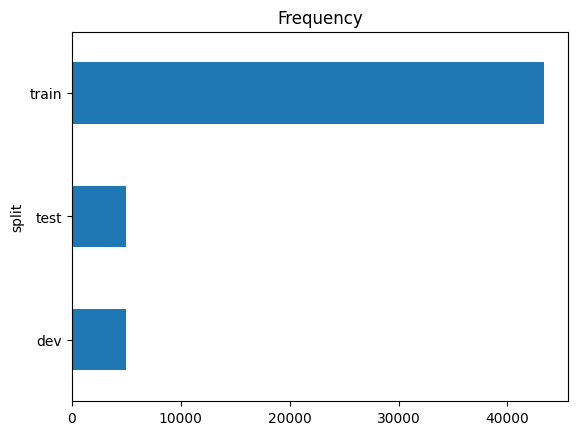

In [6]:
# Distribución de instancias por split

import matplotlib.pyplot as plt

df["split"].value_counts(ascending=True).plot.barh()
plt.title("Frequency")
plt.rcParams['figure.figsize'] = [10, 80]
plt.show()

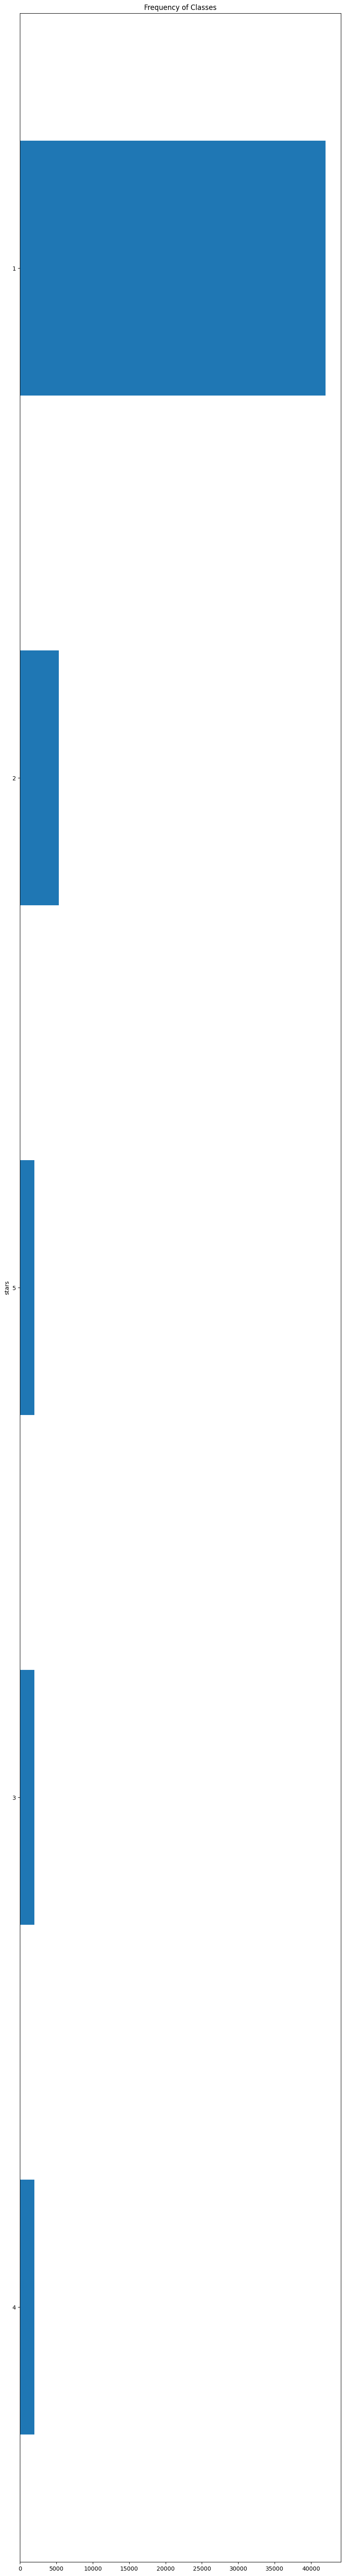

In [7]:
# Distribucion de instancias por clases (i.e. estrellas)

df["stars"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.rcParams['figure.figsize'] = [10, 80]
plt.show()

Vamos a dividir nuevamente el dataframe en tres y aleatorizar los conjuntos de datos, que estaban ordenados en función del número de estrellas.

In [8]:
import random
random.seed(0)

df_train = df[df['split'] == 'train'][['review_body', 'stars']]
df_valid = df[df['split'] == 'dev'][['review_body', 'stars']]
df_test = df[df['split'] == 'test'][['review_body', 'stars']]

df_train = df_train.sample(frac=1)
df_valid = df_valid.sample(frac=1)
df_test = df_test.sample(frac=1)

Para agilizar el proceso de finetuning de nuestro modelo con el dataset, vamos a seleccionar el 10% del dataset de entrenamiento mismo respetando la distribución equilibrada de clases.

In [9]:
from sklearn.model_selection import train_test_split

# Supongamos que ya tienes tu DataFrame df_train

# Fijamos una semilla para reproducibilidad
seed = 42
# Obtenemos el 10% del dataset de forma estratificada (por la columna "stars")
df_train, _ = train_test_split(
    df_train,
    test_size=0.9,  # 90% se descarta, 10% se conserva
    stratify=df_train["stars"],
    random_state=seed
)

In [10]:
df_train

,review_body,stars
43044,Pretty sure these batteries had terrible longe...,2
25812,Install was simple and fit like the factory on...,1
8587,Box and product was damaged!! Not happy when m...,1
13081,So the bag I received was not what I purchased...,1
23926,This is the third time I’ve purchased this pro...,1
...,...,...
17001,Truly disappointed in this purchase. The cords...,1
1262,Absolute piece of junk. Display is so dim you ...,1
16994,A total garbage. I am using this pouch the sec...,1
349,Spilled everywhere and all over my non returna...,1


Vamos a convertir los dataframes en datasets de HuggingFace, librería que vamos a utilizar para hacer aprendizaje transferido con un transformador. Intalaremos HuggingFace y la librería Dataset.

In [11]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which

In [12]:
from datasets import Dataset, DatasetDict

dataset = DatasetDict({
    "train": Dataset.from_pandas(df_train.reset_index(drop=True)),
    "valid": Dataset.from_pandas(df_valid.reset_index(drop=True)),
     "test": Dataset.from_pandas(df_test.reset_index(drop=True))
    }
    )
dataset

DatasetDict({
    train: Dataset({
        features: ['review_body', 'stars'],
        num_rows: 4336
    })
    valid: Dataset({
        features: ['review_body', 'stars'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['review_body', 'stars'],
        num_rows: 5000
    })
})

In [13]:
dataset['train'][122]

{'review_body': "Tastes like burnt french fries. I don't recommend. I wouldn't buy, they are hard and taste like burnt cheese. The also arrived in pieces and crumbled, hardly any actual squares.",
 'stars': 1}

Vamos a preparar las etiquetas de las categorías de estrellas para poder usar el transformador.

La línea dataset = dataset.class_encode_column("stars") convierte los valores de la columna "stars" del dataset en etiquetas. Esto es necesario para que la función de pérdida "CrossEntropyLoss" de PyTorch pueda procesar los datos.

La línea labels = dataset['train'].features['stars'] obtiene un objeto "ClassLabel" que contiene la información de las etiquetas de clase del conjunto de entrenamiento.

La línea dataset = dataset.rename_column("stars", "label") renombra la columna "stars" del dataset a "label". Esto es necesario para que el conjunto de datos tenga una columna con el nombre esperado por el modelo de clasificación de secuencias de Hugging Face.

La línea print(labels.names) imprime los nombres de las etiquetas de clase del conjunto de entrenamiento.

In [14]:
dataset = dataset.class_encode_column("stars")
dataset = dataset.rename_column("stars", "label")
labels = dataset['train'].features['label']
print(labels.names)

Stringifying the column:   0%|          | 0/4336 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/4336 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/5000 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/5000 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/5000 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/5000 [00:00<?, ? examples/s]

['1', '2']


# Aprendizaje transferido con Transformadores

Vamos a utilizar la librería Transformers de Hugging Face para entrenar un modelo de clasificación de secuencias utilizando un modelo de transformador preentrenado.

Aquí hay una explicación detallada:

  1. Se importan varias clases y funciones de la librería Transformers de Hugging Face.
  2. Se asigna a la variable transformer_model el nombre de un modelo de transformador preentrenado.
  3. Se crea una instancia del tokenizador asociado al modelo de transformador especificado en la variable transformer_model.
  4. Se define una función tokenize que toma las instancias del dataset y tokeniza los textos utilizando el tokenizador del modelo cargado. Los parámetros truncation y padding son utilizados por el tokenizador de la librería Transformers para procesar los datos de entrada. truncation indica si se deben recortar los datos de entrada que superen un cierto límite de longitud. Si se establece en True, el tokenizador recortará los datos de entrada a la longitud máxima especificada y agregará una marca de final de secuencia (eos_token) al final del trozo recortado. Si se establece en False, el tokenizador devolverá un error si los datos de entrada exceden la longitud máxima especificada. padding se encargará de rellenar con 0 toda la secuencia hasta llegar a la longitud máxima de tokens por secuencia (512 para BERT y derivados).
  5. Se aplica la función tokenize al dataset usando el método map. El resultado se almacena en la variable ds.
  6. Se determina si hay una GPU disponible y, de ser así, se asigna a la variable device el dispositivo "cuda", de lo contrario se asigna "cpu".
  4. Se crea una instancia del modelo de transfomador especificado en la variable transformer_model, se establece el número de etiquetas en len(labels_classes) y se carga en el dispositivo especificado en la variable device.
  
   

La secuencia de entrada se divide en subpalabras usando un algoritmo (WordPiece, en el caso de BERT), lo que permite manejar palabras desconocidas y reducir el tamaño del vocabulario.

In [15]:
from transformers import AutoTokenizer
import torch

transformer_model = 'prajjwal1/bert-tiny'
tokenizer = AutoTokenizer.from_pretrained(transformer_model)

def tokenize(examples):
    return tokenizer(examples["review_body"], padding="max_length", truncation=True, max_length=512)

ds = dataset.map(tokenize, batched=True)
ds

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Map:   0%|          | 0/4336 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['review_body', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4336
    })
    valid: Dataset({
        features: ['review_body', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['review_body', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5000
    })
})

In [16]:
from transformers import  AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = (AutoModelForSequenceClassification.from_pretrained(transformer_model, num_labels = len(labels.names)).to(device))

pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
ds['train'][0]

{'review_body': 'Pretty sure these batteries had terrible longevity in my various smart devices (e.g. door contact sensors) vs energizer.',
 'label': 1,
 'input_ids': [101,
  3492,
  2469,
  2122,
  10274,
  2018,
  6659,
  26906,
  1999,
  2026,
  2536,
  6047,
  5733,
  1006,
  1041,
  1012,
  1043,
  1012,
  2341,
  3967,
  13907,
  1007,
  5443,
  4372,
  2121,
  5856,
  6290,
  1012,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
 

Las características input_ids y attention_mask son utilizadas para procesar los datos de entrada.


    'input_ids': una lista de números enteros que representan los índices de tokens del tweet en el vocabulario del tokenizador.
    'attention_mask': una lista de números binarios que indican qué tokens del tweet deben tener en cuenta al realizar el procesamiento.

Internamente, cuando pasamos los input_ids, que representan los tokens, al modelo, BERT los convierte en embeddings. Esto sucede dentro de la arquitectura del modelo pre-entrenado. Estos vectores se combinan con embeddings posicionales. Los embeddings se procesan a través de capas bidireccionales de Transformers que usan auto-atención para capturar relaciones entre palabras en toda la secuencia. Esta parte se maneja internamente en el modelo de BERT que hemos cargado. Cuando se llama a model(...), BERT procesa la entrada a través de sus múltiples capas de transformador.

Más adelante, el modelo de BERT extrae la representación del token [CLS] (a menudo accesible como pooler_output), y esa representación se utiliza en el cabezal de clasificación.
En el modelo pre-entrenado, esta representación se proyecta luego a través del cabezal de clasificación.

Definimos las métricas de evaluación mediante una función compute_metrics que se utiliza para calcular varias métricas de rendimiento para un modelo de clasificación. Esta función toma una tupla eval_pred como entrada y devuelve un diccionario con las métricas de rendimiento calculadas.

In [18]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np  # Asegúrate de importar numpy para poder usar np.argmax

# Definimos la función compute_metrics que recibirá un argumento 'eval_pred'
def compute_metrics(eval_pred):
    # Desempaquetamos 'eval_pred' en dos variables:
    # 'logits' son las salidas sin procesar (raw outputs) del modelo para cada ejemplo.
    # 'labels' son las etiquetas verdaderas correspondientes a esos ejemplos.
    logits, labels = eval_pred

    # Convertimos los logits en predicciones finales tomando el índice con el valor máximo a lo largo del eje de clases.
    # Este índice representa la clase predicha para cada ejemplo.
    predictions = np.argmax(logits, axis=-1) # axis=-1 porque tomamos el valor máximo de la última dimensión, es decir, la columna que representa las claswa

    # Calculamos la precisión (accuracy) comparando las etiquetas verdaderas con las predichas.
    acc = accuracy_score(labels, predictions)

    # Calculamos la puntuación F1 macro.
    # 'average="macro"' calcula la F1 para cada clase y luego toma el promedio sin ponderar, lo que permite ver el rendimiento general
    # considerando todas las clases de forma igualitaria.
    macro_f1 = f1_score(labels, predictions, average='macro')

    # Retornamos un diccionario con las métricas calculadas, que en este caso son "accuracy" y "macro_f1".
    return {"accuracy": acc, "macro_f1": macro_f1}


# Entrenamiento con distintos parámetros

Este código es utilizado para entrenar un modelo de transformadores utilizando la clase Trainer.

En primer lugar, se establecen algunos parámetros de entrenamiento, como el tamaño del lote, el nombre del modelo finetuned, el número de épocas de entrenamiento, la tasa de aprendizaje, la relación de calentamiento, la tasa de decaimiento del peso, la estrategia de evaluación, la estrategia de guardado, la métrica para el mejor modelo y la opción de cargar el mejor modelo al final del entrenamiento. Estos parámetros se almacenan en la variable training_args utilizando la clase TrainingArguments de transformers.

Luego se crea una instancia de la clase Trainer pasándole como argumentos el modelo, los parámetros de entrenamiento, la función de cálculo de métricas, el conjunto de datos de entrenamiento, el conjunto de datos de validación, el tokenizador y el DataCollator.

Por último, se llama al método train de la instancia del entrenador para iniciar el proceso de entrenamiento. Durante el entrenamiento, se calculará la pérdida de entrenamiento. Además, se calcularán las métricas de evaluación en el conjunto de datos de validación y se guardará el mejor modelo en función de la métrica especificada.

Para más info acerca de los parámetros que se pueden utilizar, consulta: https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments

## Entrenamiento con 5 epochs y 2e-5 de learning rate

In [20]:
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding

batch_size = 16
model_name = "finetuned_model_sentiment_analysis_amazon"
training_args = TrainingArguments(
        output_dir=model_name,
        num_train_epochs=5,
        learning_rate = 2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_ratio=0.1,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        metric_for_best_model = "macro_f1",
        load_best_model_at_end=True,
        save_total_limit = 1,
        report_to='none',
    )

# Para algunos modelos que necesitan manejar secuencias de diversas longitudes
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=ds["train"],
                  eval_dataset=ds["valid"],
                  data_collator=data_collator
                  )
trainer.train()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


Evaluamos el mejor modelo entrenado en el conjunto de prueba y obtenemos las métricas de evaluación.

In [ ]:
preds_output = trainer.predict(ds['test'])
print(preds_output.metrics)

{'test_loss': 1.1899597644805908, 'test_accuracy': 0.486, 'test_macro_f1': 0.4755701897431612, 'test_runtime': 10.5826, 'test_samples_per_second': 472.475, 'test_steps_per_second': 29.577}


Obtenemos el informe de clasificación global y detallado de las predicciones hechas por el mejor modelo en función de las clases.

In [ ]:
from sklearn.metrics import classification_report
# ------------------------------------------------------------------------------------
# Convertimos las etiquetas verdaderas del conjunto de test a un array de NumPy.
# ds['test']["label"] se asume que es la columna que contiene las etiquetas (targets)
# del dataset de prueba.
y_true = np.array(ds['test']["label"])

# ------------------------------------------------------------------------------------
# preds_output es un objeto que contiene las salidas del modelo al hacer predicciones
# sobre el conjunto de test. Normalmente, preds_output.predictions es un array de
# logits (valores sin procesar) de forma [n_ejemplos, n_clases].
#
# Con np.argmax(preds_output.predictions, axis=-1) obtenemos, para cada ejemplo,
# el índice de la clase con el mayor valor. Es decir, convertimos los logits en la clase
# predicha para cada muestra.
y_pred = preds_output.predictions.argmax(-1)

# target_names se usa para asignar nombres legibles a cada clase (por ejemplo, "positiva",
# "negativa", etc.), lo que facilita la interpretación del informe.
report = classification_report(
  y_true,          # Etiquetas reales del conjunto de test
  y_pred,          # Etiquetas predichas tras aplicar argmax a los logits del modelo
  target_names=labels.names,  # Lista de nombres correspondientes a cada etiqueta/clase
)
print(report)

              precision    recall  f1-score   support

           1       0.58      0.71      0.64      1000
           2       0.38      0.27      0.32      1000
           3       0.35      0.39      0.36      1000
           4       0.42      0.35      0.38      1000
           5       0.64      0.71      0.67      1000

    accuracy                           0.49      5000
   macro avg       0.47      0.49      0.48      5000
weighted avg       0.47      0.49      0.48      5000



## Entrenamiento con 3 epochs y 10e-5 de learning rate

In [ ]:
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding

batch_size = 16
model_name = "finetuned_model_sentiment_analysis_amazon"
training_args = TrainingArguments(
        output_dir=model_name,
        num_train_epochs=5,
        learning_rate = 2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_ratio=0.1,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        metric_for_best_model = "macro_f1",
        load_best_model_at_end=True,
        save_total_limit = 1,
        report_to='none',
    )

# Para algunos modelos que necesitan manejar secuencias de diversas longitudes
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=ds["train"],
                  eval_dataset=ds["valid"],
                  data_collator=data_collator
                  )
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,1.516700,1.374504,0.412400,0.396150
2,1.286800,1.258113,0.458600,0.439061
3,1.230500,1.213869,0.470400,0.463057
4,1.192300,1.200876,0.477000,0.467927
5,1.184700,1.197138,0.477200,0.467974


TrainOutput(global_step=6250, training_loss=1.293213515625, metrics={'train_runtime': 335.0539, 'train_samples_per_second': 298.459, 'train_steps_per_second': 18.654, 'total_flos': 127167590400000.0, 'train_loss': 1.293213515625, 'epoch': 5.0})

Evaluamos el mejor modelo entrenado en el conjunto de prueba y obtenemos las métricas de evaluación.

In [ ]:
preds_output = trainer.predict(ds['test'])
print(preds_output.metrics)

{'test_loss': 1.1899597644805908, 'test_accuracy': 0.486, 'test_macro_f1': 0.4755701897431612, 'test_runtime': 10.5826, 'test_samples_per_second': 472.475, 'test_steps_per_second': 29.577}


Obtenemos el informe de clasificación global y detallado de las predicciones hechas por el mejor modelo en función de las clases.

In [ ]:
from sklearn.metrics import classification_report
# ------------------------------------------------------------------------------------
# Convertimos las etiquetas verdaderas del conjunto de test a un array de NumPy.
# ds['test']["label"] se asume que es la columna que contiene las etiquetas (targets)
# del dataset de prueba.
y_true = np.array(ds['test']["label"])

# ------------------------------------------------------------------------------------
# preds_output es un objeto que contiene las salidas del modelo al hacer predicciones
# sobre el conjunto de test. Normalmente, preds_output.predictions es un array de
# logits (valores sin procesar) de forma [n_ejemplos, n_clases].
#
# Con np.argmax(preds_output.predictions, axis=-1) obtenemos, para cada ejemplo,
# el índice de la clase con el mayor valor. Es decir, convertimos los logits en la clase
# predicha para cada muestra.
y_pred = preds_output.predictions.argmax(-1)

# target_names se usa para asignar nombres legibles a cada clase (por ejemplo, "positiva",
# "negativa", etc.), lo que facilita la interpretación del informe.
report = classification_report(
  y_true,          # Etiquetas reales del conjunto de test
  y_pred,          # Etiquetas predichas tras aplicar argmax a los logits del modelo
  target_names=labels.names,  # Lista de nombres correspondientes a cada etiqueta/clase
)
print(report)

              precision    recall  f1-score   support

           1       0.58      0.71      0.64      1000
           2       0.38      0.27      0.32      1000
           3       0.35      0.39      0.36      1000
           4       0.42      0.35      0.38      1000
           5       0.64      0.71      0.67      1000

    accuracy                           0.49      5000
   macro avg       0.47      0.49      0.48      5000
weighted avg       0.47      0.49      0.48      5000



## Entrenamiento con 5 epochs y 5e-5 de learning rate

In [ ]:
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding

batch_size = 16
model_name = "finetuned_model_sentiment_analysis_amazon"
training_args = TrainingArguments(
        output_dir=model_name,
        num_train_epochs=5,
        learning_rate = 2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_ratio=0.1,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        metric_for_best_model = "macro_f1",
        load_best_model_at_end=True,
        save_total_limit = 1,
        report_to='none',
    )

# Para algunos modelos que necesitan manejar secuencias de diversas longitudes
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=ds["train"],
                  eval_dataset=ds["valid"],
                  data_collator=data_collator
                  )
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,1.516700,1.374504,0.412400,0.396150
2,1.286800,1.258113,0.458600,0.439061
3,1.230500,1.213869,0.470400,0.463057
4,1.192300,1.200876,0.477000,0.467927
5,1.184700,1.197138,0.477200,0.467974


TrainOutput(global_step=6250, training_loss=1.293213515625, metrics={'train_runtime': 335.0539, 'train_samples_per_second': 298.459, 'train_steps_per_second': 18.654, 'total_flos': 127167590400000.0, 'train_loss': 1.293213515625, 'epoch': 5.0})

Evaluamos el mejor modelo entrenado en el conjunto de prueba y obtenemos las métricas de evaluación.

In [ ]:
preds_output = trainer.predict(ds['test'])
print(preds_output.metrics)

{'test_loss': 1.1899597644805908, 'test_accuracy': 0.486, 'test_macro_f1': 0.4755701897431612, 'test_runtime': 10.5826, 'test_samples_per_second': 472.475, 'test_steps_per_second': 29.577}


Obtenemos el informe de clasificación global y detallado de las predicciones hechas por el mejor modelo en función de las clases.

In [ ]:
from sklearn.metrics import classification_report
# ------------------------------------------------------------------------------------
# Convertimos las etiquetas verdaderas del conjunto de test a un array de NumPy.
# ds['test']["label"] se asume que es la columna que contiene las etiquetas (targets)
# del dataset de prueba.
y_true = np.array(ds['test']["label"])

# ------------------------------------------------------------------------------------
# preds_output es un objeto que contiene las salidas del modelo al hacer predicciones
# sobre el conjunto de test. Normalmente, preds_output.predictions es un array de
# logits (valores sin procesar) de forma [n_ejemplos, n_clases].
#
# Con np.argmax(preds_output.predictions, axis=-1) obtenemos, para cada ejemplo,
# el índice de la clase con el mayor valor. Es decir, convertimos los logits en la clase
# predicha para cada muestra.
y_pred = preds_output.predictions.argmax(-1)

# target_names se usa para asignar nombres legibles a cada clase (por ejemplo, "positiva",
# "negativa", etc.), lo que facilita la interpretación del informe.
report = classification_report(
  y_true,          # Etiquetas reales del conjunto de test
  y_pred,          # Etiquetas predichas tras aplicar argmax a los logits del modelo
  target_names=labels.names,  # Lista de nombres correspondientes a cada etiqueta/clase
)
print(report)

              precision    recall  f1-score   support

           1       0.58      0.71      0.64      1000
           2       0.38      0.27      0.32      1000
           3       0.35      0.39      0.36      1000
           4       0.42      0.35      0.38      1000
           5       0.64      0.71      0.67      1000

    accuracy                           0.49      5000
   macro avg       0.47      0.49      0.48      5000
weighted avg       0.47      0.49      0.48      5000



## Entrenamiento con 10 epochs y 2e-5 de learning rate

In [ ]:
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding

batch_size = 16
model_name = "finetuned_model_sentiment_analysis_amazon"
training_args = TrainingArguments(
        output_dir=model_name,
        num_train_epochs=5,
        learning_rate = 2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_ratio=0.1,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        metric_for_best_model = "macro_f1",
        load_best_model_at_end=True,
        save_total_limit = 1,
        report_to='none',
    )

# Para algunos modelos que necesitan manejar secuencias de diversas longitudes
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=ds["train"],
                  eval_dataset=ds["valid"],
                  data_collator=data_collator
                  )
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,1.516700,1.374504,0.412400,0.396150
2,1.286800,1.258113,0.458600,0.439061
3,1.230500,1.213869,0.470400,0.463057
4,1.192300,1.200876,0.477000,0.467927
5,1.184700,1.197138,0.477200,0.467974


TrainOutput(global_step=6250, training_loss=1.293213515625, metrics={'train_runtime': 335.0539, 'train_samples_per_second': 298.459, 'train_steps_per_second': 18.654, 'total_flos': 127167590400000.0, 'train_loss': 1.293213515625, 'epoch': 5.0})

Evaluamos el mejor modelo entrenado en el conjunto de prueba y obtenemos las métricas de evaluación.

In [ ]:
preds_output = trainer.predict(ds['test'])
print(preds_output.metrics)

{'test_loss': 1.1899597644805908, 'test_accuracy': 0.486, 'test_macro_f1': 0.4755701897431612, 'test_runtime': 10.5826, 'test_samples_per_second': 472.475, 'test_steps_per_second': 29.577}


Obtenemos el informe de clasificación global y detallado de las predicciones hechas por el mejor modelo en función de las clases.

In [ ]:
from sklearn.metrics import classification_report
# ------------------------------------------------------------------------------------
# Convertimos las etiquetas verdaderas del conjunto de test a un array de NumPy.
# ds['test']["label"] se asume que es la columna que contiene las etiquetas (targets)
# del dataset de prueba.
y_true = np.array(ds['test']["label"])

# ------------------------------------------------------------------------------------
# preds_output es un objeto que contiene las salidas del modelo al hacer predicciones
# sobre el conjunto de test. Normalmente, preds_output.predictions es un array de
# logits (valores sin procesar) de forma [n_ejemplos, n_clases].
#
# Con np.argmax(preds_output.predictions, axis=-1) obtenemos, para cada ejemplo,
# el índice de la clase con el mayor valor. Es decir, convertimos los logits en la clase
# predicha para cada muestra.
y_pred = preds_output.predictions.argmax(-1)

# target_names se usa para asignar nombres legibles a cada clase (por ejemplo, "positiva",
# "negativa", etc.), lo que facilita la interpretación del informe.
report = classification_report(
  y_true,          # Etiquetas reales del conjunto de test
  y_pred,          # Etiquetas predichas tras aplicar argmax a los logits del modelo
  target_names=labels.names,  # Lista de nombres correspondientes a cada etiqueta/clase
)
print(report)

              precision    recall  f1-score   support

           1       0.58      0.71      0.64      1000
           2       0.38      0.27      0.32      1000
           3       0.35      0.39      0.36      1000
           4       0.42      0.35      0.38      1000
           5       0.64      0.71      0.67      1000

    accuracy                           0.49      5000
   macro avg       0.47      0.49      0.48      5000
weighted avg       0.47      0.49      0.48      5000



## Entrenamiento con x epochs, x de learning rate y weight decay de 0.01

In [ ]:
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding

batch_size = 16
model_name = "finetuned_model_sentiment_analysis_amazon"
training_args = TrainingArguments(
        output_dir=model_name,
        num_train_epochs=5,
        learning_rate = 2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_ratio=0.1,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        metric_for_best_model = "macro_f1",
        load_best_model_at_end=True,
        save_total_limit = 1,
        report_to='none',
    )

# Para algunos modelos que necesitan manejar secuencias de diversas longitudes
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=ds["train"],
                  eval_dataset=ds["valid"],
                  data_collator=data_collator
                  )
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,1.516700,1.374504,0.412400,0.396150
2,1.286800,1.258113,0.458600,0.439061
3,1.230500,1.213869,0.470400,0.463057
4,1.192300,1.200876,0.477000,0.467927
5,1.184700,1.197138,0.477200,0.467974


TrainOutput(global_step=6250, training_loss=1.293213515625, metrics={'train_runtime': 335.0539, 'train_samples_per_second': 298.459, 'train_steps_per_second': 18.654, 'total_flos': 127167590400000.0, 'train_loss': 1.293213515625, 'epoch': 5.0})

Evaluamos el mejor modelo entrenado en el conjunto de prueba y obtenemos las métricas de evaluación.

In [ ]:
preds_output = trainer.predict(ds['test'])
print(preds_output.metrics)

{'test_loss': 1.1899597644805908, 'test_accuracy': 0.486, 'test_macro_f1': 0.4755701897431612, 'test_runtime': 10.5826, 'test_samples_per_second': 472.475, 'test_steps_per_second': 29.577}


Obtenemos el informe de clasificación global y detallado de las predicciones hechas por el mejor modelo en función de las clases.

In [ ]:
from sklearn.metrics import classification_report
# ------------------------------------------------------------------------------------
# Convertimos las etiquetas verdaderas del conjunto de test a un array de NumPy.
# ds['test']["label"] se asume que es la columna que contiene las etiquetas (targets)
# del dataset de prueba.
y_true = np.array(ds['test']["label"])

# ------------------------------------------------------------------------------------
# preds_output es un objeto que contiene las salidas del modelo al hacer predicciones
# sobre el conjunto de test. Normalmente, preds_output.predictions es un array de
# logits (valores sin procesar) de forma [n_ejemplos, n_clases].
#
# Con np.argmax(preds_output.predictions, axis=-1) obtenemos, para cada ejemplo,
# el índice de la clase con el mayor valor. Es decir, convertimos los logits en la clase
# predicha para cada muestra.
y_pred = preds_output.predictions.argmax(-1)

# target_names se usa para asignar nombres legibles a cada clase (por ejemplo, "positiva",
# "negativa", etc.), lo que facilita la interpretación del informe.
report = classification_report(
  y_true,          # Etiquetas reales del conjunto de test
  y_pred,          # Etiquetas predichas tras aplicar argmax a los logits del modelo
  target_names=labels.names,  # Lista de nombres correspondientes a cada etiqueta/clase
)
print(report)

              precision    recall  f1-score   support

           1       0.58      0.71      0.64      1000
           2       0.38      0.27      0.32      1000
           3       0.35      0.39      0.36      1000
           4       0.42      0.35      0.38      1000
           5       0.64      0.71      0.67      1000

    accuracy                           0.49      5000
   macro avg       0.47      0.49      0.48      5000
weighted avg       0.47      0.49      0.48      5000



## Entrenamiento con x epochs, x de learning rate y weight decay de 0.05

In [ ]:
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding

batch_size = 16
model_name = "finetuned_model_sentiment_analysis_amazon"
training_args = TrainingArguments(
        output_dir=model_name,
        num_train_epochs=5,
        learning_rate = 2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_ratio=0.1,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        metric_for_best_model = "macro_f1",
        load_best_model_at_end=True,
        save_total_limit = 1,
        report_to='none',
    )

# Para algunos modelos que necesitan manejar secuencias de diversas longitudes
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=ds["train"],
                  eval_dataset=ds["valid"],
                  data_collator=data_collator
                  )
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,1.516700,1.374504,0.412400,0.396150
2,1.286800,1.258113,0.458600,0.439061
3,1.230500,1.213869,0.470400,0.463057
4,1.192300,1.200876,0.477000,0.467927
5,1.184700,1.197138,0.477200,0.467974


TrainOutput(global_step=6250, training_loss=1.293213515625, metrics={'train_runtime': 335.0539, 'train_samples_per_second': 298.459, 'train_steps_per_second': 18.654, 'total_flos': 127167590400000.0, 'train_loss': 1.293213515625, 'epoch': 5.0})

Evaluamos el mejor modelo entrenado en el conjunto de prueba y obtenemos las métricas de evaluación.

In [ ]:
preds_output = trainer.predict(ds['test'])
print(preds_output.metrics)

{'test_loss': 1.1899597644805908, 'test_accuracy': 0.486, 'test_macro_f1': 0.4755701897431612, 'test_runtime': 10.5826, 'test_samples_per_second': 472.475, 'test_steps_per_second': 29.577}


Obtenemos el informe de clasificación global y detallado de las predicciones hechas por el mejor modelo en función de las clases.

In [ ]:
from sklearn.metrics import classification_report
# ------------------------------------------------------------------------------------
# Convertimos las etiquetas verdaderas del conjunto de test a un array de NumPy.
# ds['test']["label"] se asume que es la columna que contiene las etiquetas (targets)
# del dataset de prueba.
y_true = np.array(ds['test']["label"])

# ------------------------------------------------------------------------------------
# preds_output es un objeto que contiene las salidas del modelo al hacer predicciones
# sobre el conjunto de test. Normalmente, preds_output.predictions es un array de
# logits (valores sin procesar) de forma [n_ejemplos, n_clases].
#
# Con np.argmax(preds_output.predictions, axis=-1) obtenemos, para cada ejemplo,
# el índice de la clase con el mayor valor. Es decir, convertimos los logits en la clase
# predicha para cada muestra.
y_pred = preds_output.predictions.argmax(-1)

# target_names se usa para asignar nombres legibles a cada clase (por ejemplo, "positiva",
# "negativa", etc.), lo que facilita la interpretación del informe.
report = classification_report(
  y_true,          # Etiquetas reales del conjunto de test
  y_pred,          # Etiquetas predichas tras aplicar argmax a los logits del modelo
  target_names=labels.names,  # Lista de nombres correspondientes a cada etiqueta/clase
)
print(report)

              precision    recall  f1-score   support

           1       0.58      0.71      0.64      1000
           2       0.38      0.27      0.32      1000
           3       0.35      0.39      0.36      1000
           4       0.42      0.35      0.38      1000
           5       0.64      0.71      0.67      1000

    accuracy                           0.49      5000
   macro avg       0.47      0.49      0.48      5000
weighted avg       0.47      0.49      0.48      5000



## Entrenamiento con x epochs, x de learning rate y weight decay de 0.1

In [ ]:
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding

batch_size = 16
model_name = "finetuned_model_sentiment_analysis_amazon"
training_args = TrainingArguments(
        output_dir=model_name,
        num_train_epochs=5,
        learning_rate = 2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_ratio=0.1,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        metric_for_best_model = "macro_f1",
        load_best_model_at_end=True,
        save_total_limit = 1,
        report_to='none',
    )

# Para algunos modelos que necesitan manejar secuencias de diversas longitudes
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=ds["train"],
                  eval_dataset=ds["valid"],
                  data_collator=data_collator
                  )
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,1.516700,1.374504,0.412400,0.396150
2,1.286800,1.258113,0.458600,0.439061
3,1.230500,1.213869,0.470400,0.463057
4,1.192300,1.200876,0.477000,0.467927
5,1.184700,1.197138,0.477200,0.467974


TrainOutput(global_step=6250, training_loss=1.293213515625, metrics={'train_runtime': 335.0539, 'train_samples_per_second': 298.459, 'train_steps_per_second': 18.654, 'total_flos': 127167590400000.0, 'train_loss': 1.293213515625, 'epoch': 5.0})

Evaluamos el mejor modelo entrenado en el conjunto de prueba y obtenemos las métricas de evaluación.

In [ ]:
preds_output = trainer.predict(ds['test'])
print(preds_output.metrics)

{'test_loss': 1.1899597644805908, 'test_accuracy': 0.486, 'test_macro_f1': 0.4755701897431612, 'test_runtime': 10.5826, 'test_samples_per_second': 472.475, 'test_steps_per_second': 29.577}


Obtenemos el informe de clasificación global y detallado de las predicciones hechas por el mejor modelo en función de las clases.

In [ ]:
from sklearn.metrics import classification_report
# ------------------------------------------------------------------------------------
# Convertimos las etiquetas verdaderas del conjunto de test a un array de NumPy.
# ds['test']["label"] se asume que es la columna que contiene las etiquetas (targets)
# del dataset de prueba.
y_true = np.array(ds['test']["label"])

# ------------------------------------------------------------------------------------
# preds_output es un objeto que contiene las salidas del modelo al hacer predicciones
# sobre el conjunto de test. Normalmente, preds_output.predictions es un array de
# logits (valores sin procesar) de forma [n_ejemplos, n_clases].
#
# Con np.argmax(preds_output.predictions, axis=-1) obtenemos, para cada ejemplo,
# el índice de la clase con el mayor valor. Es decir, convertimos los logits en la clase
# predicha para cada muestra.
y_pred = preds_output.predictions.argmax(-1)

# target_names se usa para asignar nombres legibles a cada clase (por ejemplo, "positiva",
# "negativa", etc.), lo que facilita la interpretación del informe.
report = classification_report(
  y_true,          # Etiquetas reales del conjunto de test
  y_pred,          # Etiquetas predichas tras aplicar argmax a los logits del modelo
  target_names=labels.names,  # Lista de nombres correspondientes a cada etiqueta/clase
)
print(report)

              precision    recall  f1-score   support

           1       0.58      0.71      0.64      1000
           2       0.38      0.27      0.32      1000
           3       0.35      0.39      0.36      1000
           4       0.42      0.35      0.38      1000
           5       0.64      0.71      0.67      1000

    accuracy                           0.49      5000
   macro avg       0.47      0.49      0.48      5000
weighted avg       0.47      0.49      0.48      5000

